#Project of 'Laboratorio di Intelligenza Artificiale'
Nevi Classification with Machine Learninig for automatic diagnosis of melanoma

[![View filled on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/ValerioSpagnoli/Nevi-Classification.git)
[![Open filled In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1e4YtGOXGq-ZCI5Iun__t99Y4HTTMuQXa?authuser=1#scrollTo=uQbBFaezBVRa)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torchaudio
import pandas as pd
import os
from skimage import io
import matplotlib.pyplot as plt
import numpy as np
from google.colab import files
import seaborn as sns

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [55]:
batch_size = 16
num_epochs = 10

###Classe del dataset ISIC
Il dataset contiene immagini di nei, suddivise in due classi: benigni e maligni (melanomi). 

In [56]:
class ISIC_Dataset(Dataset):
  def __init__(self, csv_file, img_dir, transform=None, data=None, device=None):
    self.img_labels = pd.read_csv(csv_file)
    self.img_dir = img_dir
    self.transform = transform
    self.data = data
    self.code_img = None
    self.device = device

  def __len__(self):
    return len(self.img_labels)

  def __getitem__(self, idx):
    self.code_img = self.img_labels.iloc[idx, 0]
    img_path = os.path.join(self.img_dir, self.code_img) + '.jpg'
    image = io.imread(img_path)

    #benign = 0 malignant = 1
    if(self.data == 'Train'):
      label_bm = self.img_labels.iloc[idx, 1]
      label = 0
      if(label_bm == 'malignant'): 
        label = 1

    elif(self.data == 'Test'):
      label = self.img_labels.iloc[idx, 1].astype(np.int64)


    if self.transform:
      image = self.transform(image)

    image.to(self.device)

    return image, label, self.code_img

### TrainLoader e TestLoader 
Creazione degli oggetti iterabili per scansionare il dataset

In [57]:
train_transform = transforms.Compose([transforms.ToPILImage(),
                                    transforms.Resize((256, 256)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

test_transform = transforms.Compose([transforms.ToPILImage(),
                                    transforms.Resize((256, 256)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

trainset = ISIC_Dataset(csv_file = '/content/drive/MyDrive/Università/3° ANNO/2° SEMESTRE/Laboratorio di Intelligenza Artificiale/Progetto/Dataset1/Training/ISBI2016_ISIC_Part3_Training_GroundTruth.csv', 
                        img_dir = '/content/drive/MyDrive/Università/3° ANNO/2° SEMESTRE/Laboratorio di Intelligenza Artificiale/Progetto/Dataset1/Training/ISBI2016_ISIC_Part3_Training_Data', 
                        transform = train_transform, data = 'Train', device = device)

testset = ISIC_Dataset(csv_file = '/content/drive/MyDrive/Università/3° ANNO/2° SEMESTRE/Laboratorio di Intelligenza Artificiale/Progetto/Dataset1/Test/ISBI2016_ISIC_Part3_Test_GroundTruth.csv', 
                        img_dir = '/content/drive/MyDrive/Università/3° ANNO/2° SEMESTRE/Laboratorio di Intelligenza Artificiale/Progetto/Dataset1/Test/ISBI2016_ISIC_Part3_Test_Data', 
                        transform = train_transform, data = 'Test', device = device)


train_loader = DataLoader(dataset=trainset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=testset, batch_size=batch_size, shuffle=True)

classes = ('benign', 'malignant')

benign benign benign benign malignant benign benign benign benign benign benign benign benign malignant benign benign


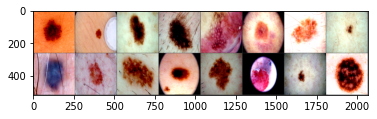

In [62]:
def imshow(img):
    img[0] = img[0]*0.485 + 0.229     # unnormalize
    img[1] = img[1]*0.456 + 0.224
    img[2] = img[2]*0.406 + 0.225
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(train_loader)
images, labels, code_img = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

Feature batch shape: torch.Size([16, 3, 256, 256])
Labels batch shape: torch.Size([16])
Label: 0


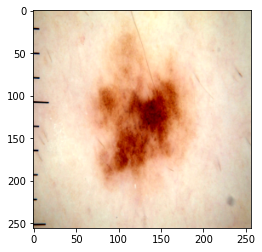

In [63]:
train_features, train_labels, code_img = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
imshow(img)
print(f"Label: {label}")

In [29]:
train_csv = trainset.img_labels
train_csv.head()

,ISIC_0000000,benign
0,ISIC_0000001,benign
1,ISIC_0000002,malignant
2,ISIC_0000004,malignant
3,ISIC_0000006,benign
4,ISIC_0000007,benign


In [11]:
train_csv.describe()

,ISIC_0000000,benign
count,899,899
unique,899,2
top,ISIC_0000001,benign
freq,1,726


In [12]:
train_csv['benign'].value_counts(normalize=True)

benign       0.807564
malignant    0.192436
Name: benign, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


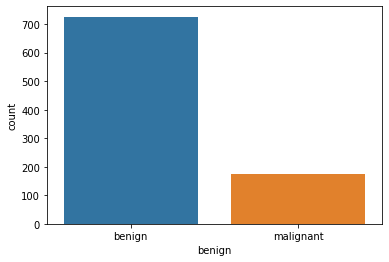

In [13]:
sns.countplot(train_csv['benign'])

In [14]:
train_csv.isna().sum() #non ci sono valori nulli

ISIC_0000000    0
benign          0
dtype: int64

In [15]:
import torch.nn as nn
import torch.nn.functional as F


class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)  # num channels (RGB), num output, filter dim
        self.pool = nn.MaxPool2d(2, 2)   # filter dim, stride
        self.conv2 = nn.Conv2d(6, 16, 5) # num input = num output conv1, num output, filter dim 
        self.fc1 = nn.Linear(16 * 61 * 61, 1200)
        self.fc2 = nn.Linear(1200, 600)
        self.fc3 = nn.Linear(600, 300)
        self.fc4 = nn.Linear(300, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 61 * 61)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        return x


net = ConvNet()
net.to(device)

ConvNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=59536, out_features=1200, bias=True)
  (fc2): Linear(in_features=1200, out_features=600, bias=True)
  (fc3): Linear(in_features=600, out_features=300, bias=True)
  (fc4): Linear(in_features=300, out_features=1, bias=True)
)

In [88]:
model =  torchvision.models.resnet18(pretrained=True, progress=True)
for params in model.parameters():
  params.requires_grad_ = False

nr_filters = model.fc.in_features
model.fc = nn.Linear(nr_filters, 1)

model.to(device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [89]:
from torch.optim import optimizer
import torch.optim as optim
import torch.nn.functional as F

criterion = nn.BCEWithLogitsLoss()
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum = 0.9)

In [90]:
for epoch in range(num_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs
        inputs, labels, code_img = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize

        #outputs = net(inputs)
        outputs = model(inputs)
        outputs = torch.transpose(outputs,-1,0)[0]

        loss = criterion(outputs, labels.float())

        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 28 == 27: 
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0

print('Finished Training')

[1,    28] loss: 0.081
[1,    56] loss: 0.066
[2,    28] loss: 0.049
[2,    56] loss: 0.054
[3,    28] loss: 0.042
[3,    56] loss: 0.038
[4,    28] loss: 0.032
[4,    56] loss: 0.025
[5,    28] loss: 0.018
[5,    56] loss: 0.020
[6,    28] loss: 0.013
[6,    56] loss: 0.014
[7,    28] loss: 0.008
[7,    56] loss: 0.007
[8,    28] loss: 0.005
[8,    56] loss: 0.005
[9,    28] loss: 0.012
[9,    56] loss: 0.007
[10,    28] loss: 0.007
[10,    56] loss: 0.005
Finished Training


###Test the network

In [91]:
test_csv = testset.img_labels
test_csv.head()

,ISIC_0000003,0.0
0,ISIC_0000012,0.0
1,ISIC_0000013,1.0
2,ISIC_0000014,0.0
3,ISIC_0000015,0.0
4,ISIC_0000020,0.0


In [92]:
test_csv['0.0'].value_counts(normalize=True)

0.0    0.801587
1.0    0.198413
Name: 0.0, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


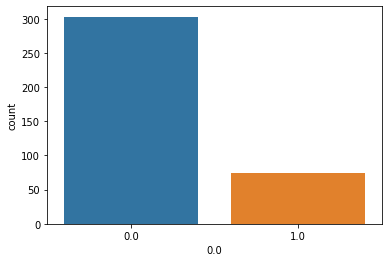

In [93]:
sns.countplot(test_csv['0.0'])

0 benign
1 benign
2 benign
3 malignant
4 benign
5 benign
6 benign
7 malignant
8 benign
9 benign
10 benign
11 benign
12 benign
13 benign
14 benign
15 benign


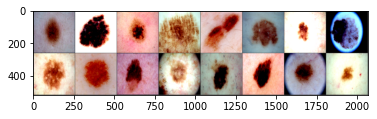

In [119]:
dataiter = iter(test_loader)
images, labels, code_img = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
for i in range(0, batch_size):
  if(labels[i]==0):
    print(i, 'benign')
  else:
    print(i, 'malignant')
#print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))
images, labels = images.to(device), labels.to(device)

In [120]:
outputs = model(images)
outputs = torch.sigmoid(outputs)

i = 0
for out in outputs:
  if out >= 0.5:
    print(i, 'malignant')
  elif out < 0.5:
    print(i, 'benign')
  i+=1

0 benign
1 benign
2 malignant
3 malignant
4 benign
5 benign
6 benign
7 malignant
8 benign
9 benign
10 benign
11 benign
12 benign
13 benign
14 benign
15 benign


In [123]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels, code_img = data
        images, labels = images.to(device), labels.to(device)
        #outputs = net(images)
        outputs = model(images)
        outputs = torch.sigmoid(outputs) 

        for i in range(0, labels.size()[0]):
          out = 0
          if(outputs[i]>=0.5):
            out = 1

          lab = labels[i]

          if(lab == out):
            correct += 1
          
          total += 1

print('Accuracy of the network on test images: %d %%' % (100 * correct / total))

Accuracy of the network on test images: 86 %


In [125]:
benign_correct = 0
benign_total = 0
malignant_correct = 0
malignant_total = 0

with torch.no_grad():
    for data in test_loader:
        images, labels, code_img = data
        images, labels = images.to(device), labels.to(device)
        #outputs = net(images)
        outputs = model(images)

        for i in range(0, labels.size()[0]):
          
          if(labels[i] == 0): # benign
            benign_total += 1
            if(outputs[i]<0.5):
              benign_correct += 1

          elif(labels[i] == 1): # benign
            malignant_total += 1
            if(outputs[i]<0.5):
              malignant_correct += 1

print('Accuracy of "benign" on test images: %d %%' % (100 * benign_correct / benign_total))
print('Accuracy of "malignant" on test images: %d %%' % (100 * malignant_correct / malignant_total))

Accuracy of "benign" on test images: 96 %
Accuracy of "malignant" on test images: 65 %
